In [397]:
from dataset import *
import seaborn as sns

# Explore IRT

## Explore IRT within same file

### Explore IRT within same file single file

In [398]:
def mean_absolute_deviation(series):
    """
    This computes the mean absolute deviation(MAD).
    Parameters:
    -----------
    series : pandas.Series
        A series of numbers from which the MAD will be calculated.

    Returns:
    --------
    float
        The mean standard deviation of the series
    """
    if len(series)<4:
        return None
    return (series - series.mean()).abs().mean()

def IRT_mad_file(file_path):
    """
    Compute the variance of the 'iRT' column grouped by 'Modified sequence' from the input file.

    Parameters:
    -----------
    file_path : str
        The file that will be loaded as a DataFrame for processing.

    Returns:
    --------
    pandas.Series
        A Series containing the variance of 'iRT' values for each group of 'Modified sequence'.
        The index of the Series represents the 'Modified sequence' and the values represent the variance.
    """
    df = load_dataframe(file_path)
    mad = df.groupby("Modified sequence")['iRT'].apply(mean_absolute_deviation).dropna()
    return mad

def plot(data, title, x_label, y_label, plot_type='hist', percentile=1):
    """
    Plot a histogram or a density plot of the input data with an adjustable percentile range.

    Parameters:
    -----------
    data : pandas.Series or array-like
        The data for which the plot will be generated.

    title : str
        The title of the plot.

    x_label : str
        The label for the x-axis.

    y_label : str
        The label for the y-axis.

    percentile : float, optional
        The percentile value used to filter out extreme values. The data is plotted within the range
        from 0 to this percentile's value. Default is 1, meaning the entire data range is plotted.

    plot_type : str, optional
        The type of plot to generate. Options are 'hist' for histogram (default) or 'kde' for density plot.
    """
    quantile = data.quantile(percentile)

    # Filter the data based on the percentile
    filtered_data = data[data <= quantile]

    # Plot based on the plot_type parameter
    if plot_type == 'hist':
        # Plot histogram
        filtered_data.plot.hist(range=(0, quantile))
    elif plot_type == 'kde':
        # Plot density plot (KDE)
        sns.kdeplot(data=filtered_data)
    elif plot_type == 'box':
        # Plot boxen plot
        sns.boxenplot(data=filtered_data)
    # Add title, label for the x-axis and y-axis
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Display the plot
    plt.show()

In [399]:
mad = IRT_mad_file("testing/data/pool_1/Thermo_SRM_Pool_1_01_01_2xIT_2xHCD-1h-R2-tryptic-evidence.txt")
mad.describe()

count    52.000000
mean      2.623419
std       2.311222
min       0.083769
25%       0.752043
50%       2.053540
75%       3.873935
max      10.262178
Name: iRT, dtype: float64

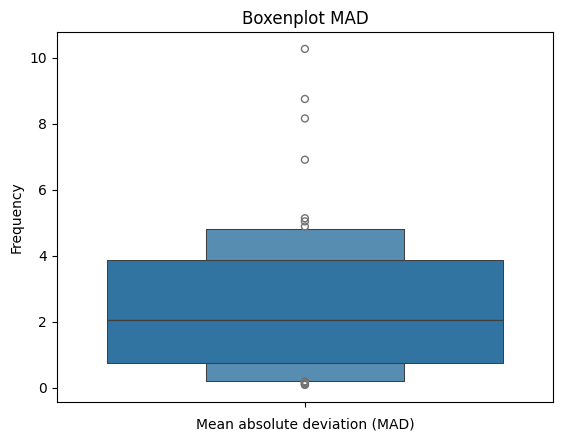

In [400]:
plot(mad,"Boxenplot MAD","Mean absolute deviation (MAD)","Frequency","box")

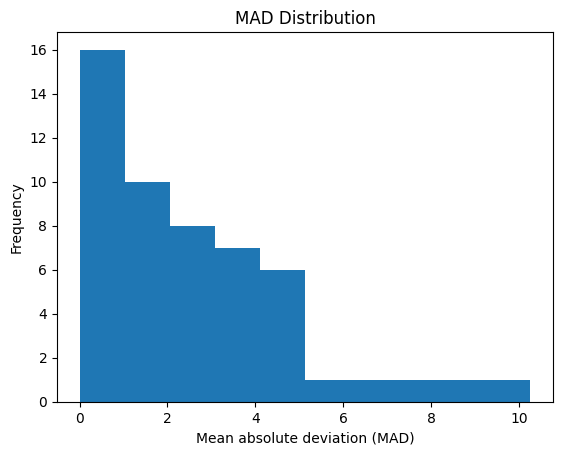

In [401]:
plot(mad,"MAD Distribution","Mean absolute deviation (MAD)","Frequency")

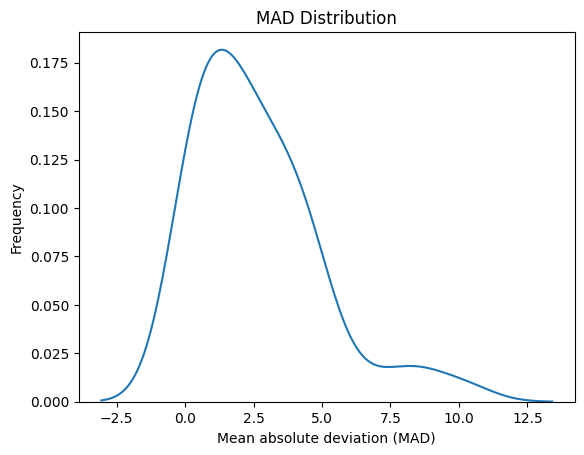

In [402]:
plot(mad,"MAD Distribution","Mean absolute deviation (MAD)","Frequency","kde")

### Explore IRT within same file all files

In [403]:
def get_mad_all_files(directory_path):
    """
    Calculate the mean absolute deviation(MAD) of 'iRT' values for multiple files in subdirectories and combine them.

    Parameters:
    -----------
    directory_path : str
        The path to the directory containing subdirectories, each with data files to process.

    Returns:
    --------
    pandas.Series
        A Series containing the MAD of 'iRT' values for each (peptide,file) combination.

    Notes:
    ------
    The directory structure should look like:
        - directory_path/
            - pool1/
                - file1.csv
                - file2.csv
            - pool2/
                - file3.csv
            ....

    """
    # Initialize a list to store MAD Series
    mads = []
    
    # Loop through each subdirectory in the specified directory path
    for pool_dir in os.listdir(directory_path):
        pool_path = os.path.join(directory_path, pool_dir)
        
        # Check if the current item is a directory
        if os.path.isdir(pool_path):
            # Loop through each file in the subdirectory
            for file in os.listdir(pool_path):
                file_path = os.path.join(pool_path, file)
                # Compute the mad of 'iRT' values for the file and append to the list
                mad = IRT_variance_file(file_path)
                mads.append(mad)
    # Concatenate all the mad series into a single series
    combined_mads = pd.concat(mads, ignore_index=True)
    return combined_mads


In [404]:
mad_all_files = get_mad_all_files(r"D:\data_preprocessed")
mad_all_files.describe()

count     45329.000000
unique    45324.000000
top           0.240489
freq          2.000000
Name: iRT, dtype: float64

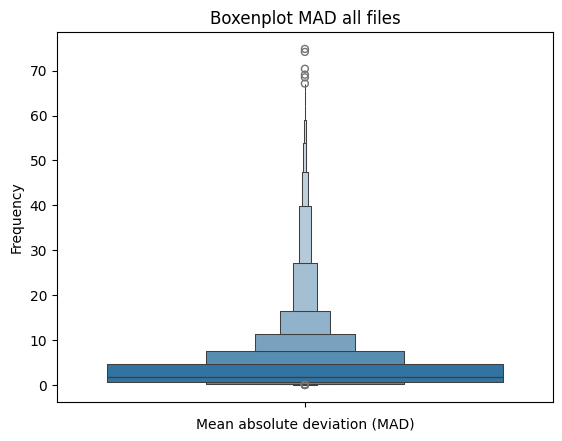

In [405]:
plot(mad_all_files,"Boxenplot MAD all files","Mean absolute deviation (MAD)","Frequency","box")

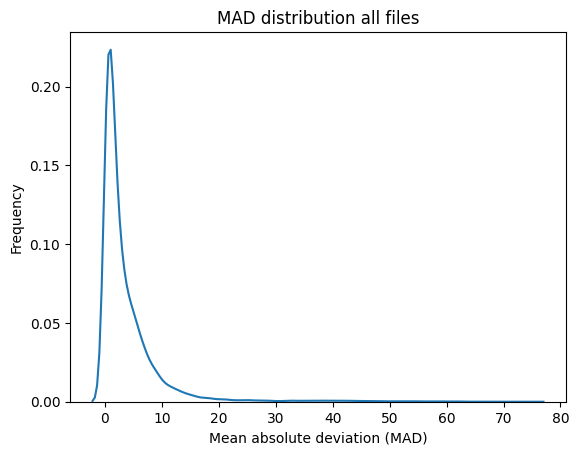

In [406]:
plot(mad_all_files,"MAD distribution all files","Mean absolute deviation (MAD)","Frequency","kde")

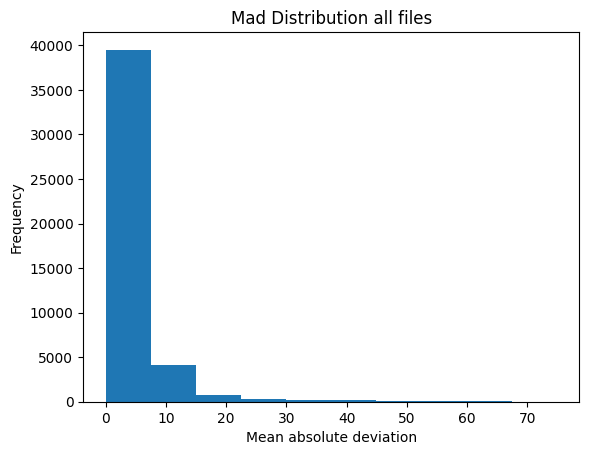

In [407]:
plot(mad_all_files,"Mad Distribution all files","Mean absolute deviation","Frequency")

## Explore IRT different files same pool

### Explore IRT different files same pool single pool

In [408]:
def get_mad_pool(directory_path):
    """
    Compute the variance of 'iRT' values for all peptides in a given pool (subdirectory) and return the variances 
    grouped by 'Modified sequence'.

    Parameters:
    -----------
    directory_path : str
        The path to the subdirectory (pool) containing the data files to process.

    Returns:
    --------
    pandas.Series
        A Series containing the variance of 'iRT' values for each peptide in the pool. The index 
        represents the 'Modified sequence', and the values are the variance of 'iRT' for each group.

    Notes:
    ------
    The directory structure should look like:
        - directory_path/
            - pool1/
                - file1.csv
                - file2.csv
            - pool2/
                - file3.csv
            ....
    """
    # Initialize a list to store DataFrames from each file in the pool
    means = []
    # Loop through each file in the specified pool directory
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        # Load the DataFrame from the file and append it to the list
        df = load_dataframe(file_path)
        grouped = df.groupby("Modified sequence")
        mean = grouped["iRT"].mean()
        means.append(mean)
    combined_means_pool = pd.concat(means, ignore_index=False)
    groups = combined_means_pool.groupby(combined_means_pool.index)
    mad = groups.apply(mean_absolute_deviation)
    return mad


In [409]:
mad_pool1 = get_mad_pool("testing/data/Pool_1")

In [410]:
mad_pool1.describe()

count    989.000000
mean       2.047162
std        2.378740
min        0.034425
25%        0.776384
50%        1.314167
75%        2.211330
max       23.728075
Name: iRT, dtype: float64

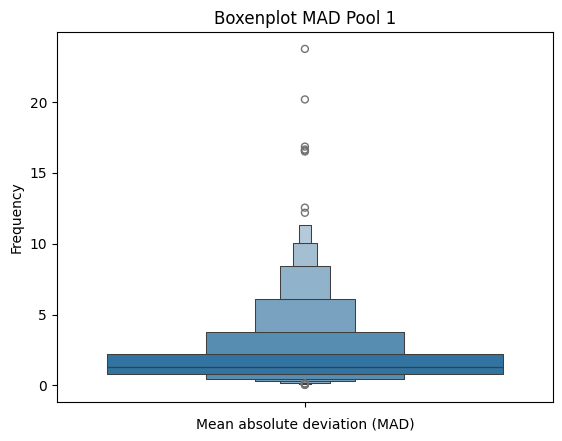

In [411]:
plot(mad_pool1,"Boxenplot MAD Pool 1","Mean absolute deviation (MAD)","Frequency","box")

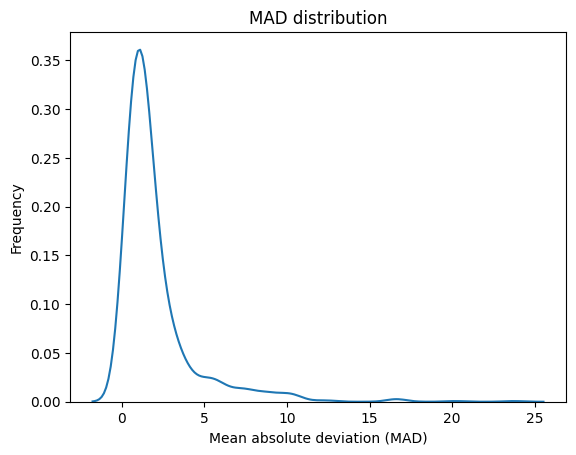

In [412]:
plot(mad_pool1,"MAD distribution","Mean absolute deviation (MAD)","Frequency","kde")

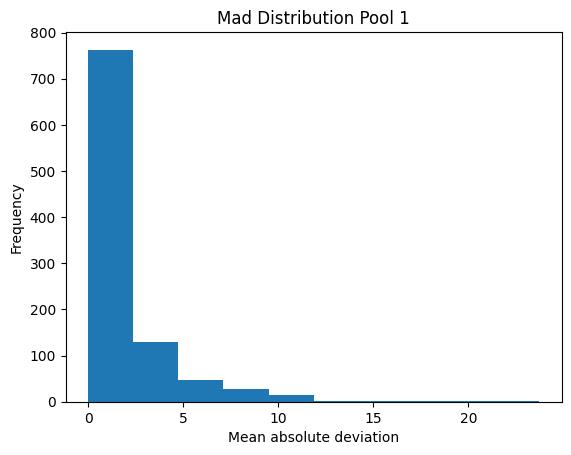

In [413]:
plot(mad_pool1,"Mad Distribution Pool 1","Mean absolute deviation","Frequency")

### Explore IRT different files same pool all pools

In [414]:
def get_mad_all_pools(directory_path):
    """
    Compute the mad of 'iRT' values for all peptides in each pool.

    Parameters:
    -----------
    directory_path : str
        The path to the main directory containing subdirectories (pools), each of which contains data files 
        to process.

    Returns:
    --------
    pandas.DataFrame
        A combined DataFrame containing the variance of 'iRT' values for each pool (subdirectory) in the directory.

    Notes:
    ------
    This function iterates through each subdirectory (pool) within the specified directory path. For each pool, 
    it computes the variance of 'iRT' values using the `get_variance_pool` function, which processes the files 
    in the subdirectory. The variances from all pools are then concatenated into a single DataFrame.

    Example:
    --------
    If the directory structure is as follows:

        directory_path/
            pool1/
                file1.csv
                file2.csv
            pool2/
                file3.csv

    The function will process each pool (e.g., `pool1`, `pool2`), compute the variance of 'iRT' values for each, 
    and return a combined DataFrame of variances from all pools.
    
    """
    # Initialize a list to store variance Series
    mads = []
    # Loop through each subdirectory in the specified directory path
    for pool_dir in os.listdir(directory_path):
        pool_path = os.path.join(directory_path, pool_dir)
        # Check if the current item is a directory
        if os.path.isdir(pool_path):
            mad = get_mad_pool(pool_path)
            mads.append(mad)
    # Concatenate all the mad DataFrames into a single DataFrame
    combined_mads = pd.concat(mads, ignore_index=True)
    return combined_mads


In [415]:
mad_all_pools = get_mad_all_pools(r"D:\data_preprocessed")

In [416]:
mad_all_pools.describe()

count    135682.000000
mean          1.286298
std           1.962730
min           0.008741
25%           0.395650
50%           0.758674
75%           1.385681
max          65.710384
Name: iRT, dtype: float64

<Axes: ylabel='iRT'>

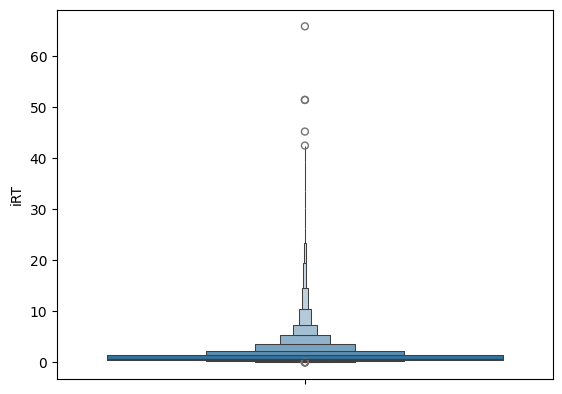

In [417]:
sns.boxenplot(data=mad_all_pools)

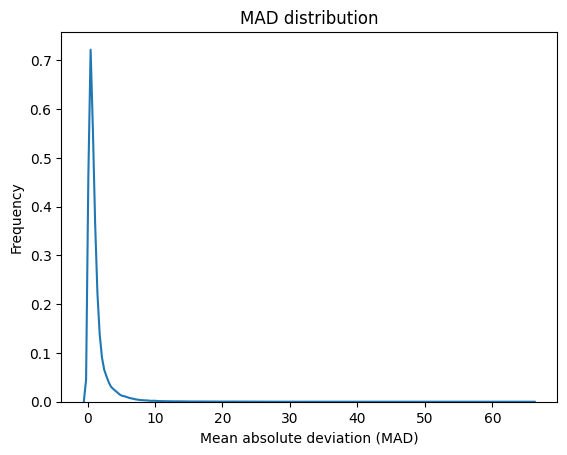

In [418]:
plot(mad_all_pools,"MAD distribution","Mean absolute deviation (MAD)","Frequency","kde")

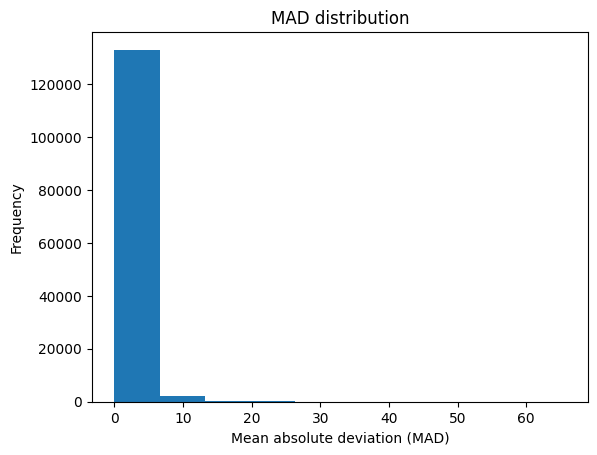

In [419]:
plot(mad_all_pools,"MAD distribution","Mean absolute deviation (MAD)","Frequency")

## Explore IRT different pools

In [420]:
def get_mad_different_pools(directory_path):
    pool_means = []
    for pool_dir in os.listdir(directory_path):
        pool_path = os.path.join(directory_path, pool_dir)
        file_means = []
        # Check if the current item is a directory
        if os.path.isdir(pool_path):
            for file in os.listdir(pool_path):
                file_path = os.path.join(pool_path,file)
                df = load_dataframe(file_path)
                file_mean = df.groupby("Modified sequence")["iRT"].mean()
                file_means.append(file_mean)
        file_combined_df = pd.concat(file_means, ignore_index=False)
        pool_mean = file_combined_df.groupby(file_combined_df.index).mean()
        pool_means.append(pool_mean)
    pools_combined = pd.concat(pool_means, ignore_index=False)
    mad = pools_combined.groupby(pools_combined.index).apply(mean_absolute_deviation)
    return mad

In [421]:
mad_different_pools = get_mad_different_pools(r"D:\data_preprocessed")

In [422]:
mad_different_pools.describe()

count    177.000000
mean       1.311434
std        3.049541
min        0.122352
25%        0.307390
50%        0.587666
75%        1.115512
max       27.319609
Name: iRT, dtype: float64

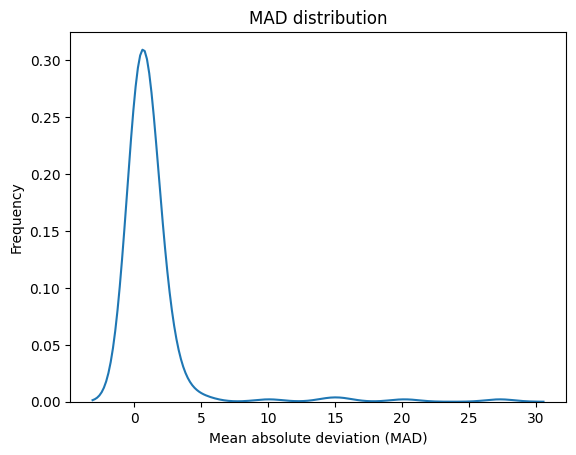

In [423]:
plot(mad_different_pools,"MAD distribution","Mean absolute deviation (MAD)","Frequency","kde")

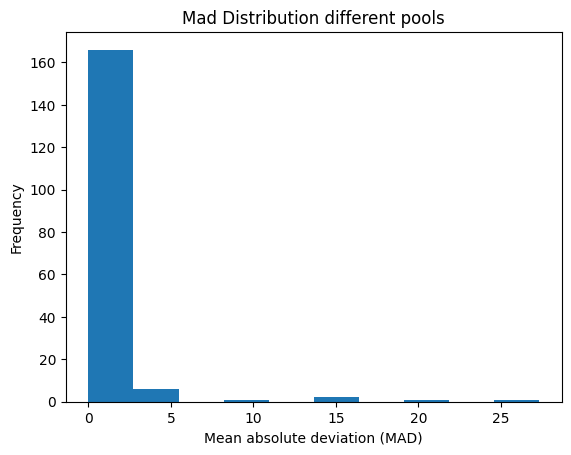

In [424]:
plot(mad_different_pools,"Mad Distribution different pools","Mean absolute deviation (MAD)","Frequency")